##**TPS09 Etchepareborda Baltazar Ariel - Naive Bayes**

###*Enunciado*
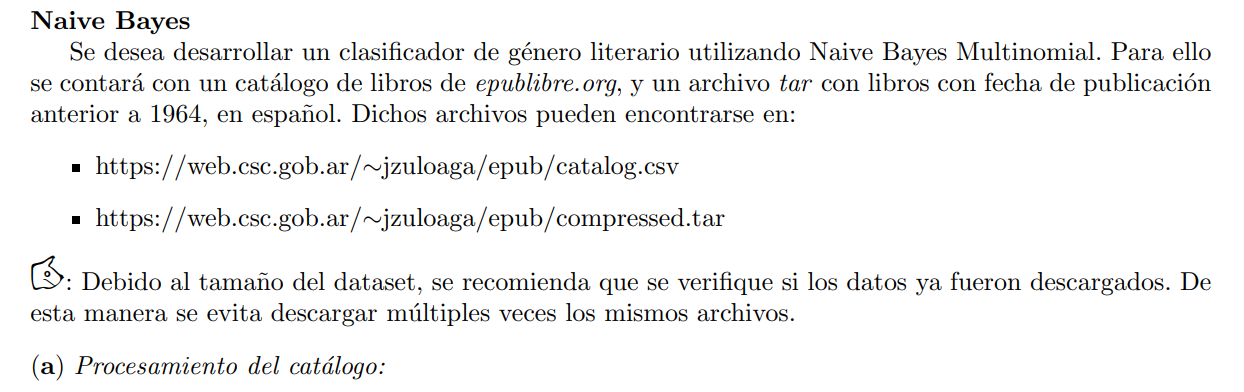

###**Procesamiento del codigo**
1. Cargar el catalogo y exploar el contenido de sus columnas. Que representa cada una?

##**Importo las librerias primero una vez**

In [1]:
!pip install ebooklib beautifulsoup4

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tarfile
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from ebooklib import epub
from bs4 import BeautifulSoup
import ebooklib
from ebooklib import epub
from scipy import sparse
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.metrics import f1_score, classification_report
import os
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Comentario: El analisis teorico de MNB esta en la seccion 3.

Primero empiezo descargando los archivos

In [3]:
#!curl -L -o catalog.csv https://web.csc.gob.ar/~jzuloaga/epub/catalog.csv
#!curl -L -o catalog.tar https://web.csc.gob.ar/~jzuloaga/epub/compressed.tar #Dejo


In [4]:
def descargar_si_no_existe(url, destino):
    if not os.path.exists(destino):
        print(f"Descargando {destino} ...")
        os.system(f"curl -L -o {destino} {url}")
    else:
        print(f" {destino} ya existe, se omite la descarga.")

# URLs y archivos destino
descargar_si_no_existe(
    "https://web.csc.gob.ar/~jzuloaga/epub/catalog.csv",
    "catalog.csv"
)

descargar_si_no_existe(
    "https://web.csc.gob.ar/~jzuloaga/epub/compressed.tar",
    "catalog.tar"
)


 catalog.csv ya existe, se omite la descarga.
 catalog.tar ya existe, se omite la descarga.


In [5]:
# Source - https://stackoverflow.com/a
# Posted by Marlon Abeykoon, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-10, License - CC BY-SA 3.0
catalog_csv = pd.read_csv('catalog.csv')
  # extracts to folder ./epubs
#!ls -lh catalog.tar Estaba vacio el archivo... Copie el enunciado y no use el ~ correcto...


In [6]:
print(catalog_csv.shape)

(69193, 16)


In [7]:
print(catalog_csv.head())


   EPL Id                          Título              Autor  \
0   78718            Cuando era divertido        Eloy Moreno   
1   80251       El laberinto de la bestia        Emily Rodda   
2   80612            A orillas del tiempo      Fernando Wulf   
3   80570  Memorias del mariscal de campo  Albert Kesselring   
4   77527                   El álbum ruso  Michael Ignatieff   

                          Géneros           Colección  Volumen  \
0                           Otros                 NaN      NaN   
1  Aventuras, Fantástico, Juvenil  La saga de Deltora      6.0   
2     Ciencias sociales, Historia                 NaN      NaN   
3              Historia, Memorias                 NaN      NaN   
4   Biografía, Historia, Memorias                 NaN      NaN   

   Año publicación                                           Sinopsis  \
0             2022  Quizás hay un momento en la vida para leer est...   
1             2000  Lief, Barda y Jasmine siguen buscando las siet...   

In [8]:
print(catalog_csv['Estado'].value_counts())


Estado
Disp.    55425
Ver.     13768
Name: count, dtype: int64


EPL ID representa el identificador único del libro dentro del sistema. Sirve para vincularlo con su archivo correspondiente, por ejemplo `compressed/78718.epub`.

Título es el nombre del libro.

Autor indica quién lo escribió. Puede haber más de un autor separado por coma.

Géneros describe la categoría o tipo de contenido, por ejemplo “Aventura”, “Fantástico” o “Juvenil”.

Colección señala a qué conjunto o saga pertenece el libro, si aplica. Si no pertenece a ninguna puede estar vacío.

Volumen indica el número dentro de la colección o saga. Puede tener valores decimales si la colección los usa.

Año de publicación corresponde al año en que fue publicado originalmente el libro.

Sinopsis es una breve descripción o resumen del contenido del libro.

Páginas indica la cantidad total de páginas que tiene el libro.

Revisión representa la versión del archivo dentro de la biblioteca; si es la única versión suele ser 1.0.

Idioma señala el idioma en que está escrito el libro.

Publicado indica la fecha de publicación o actualización.

Estado muestra la disponibilidad del libro dentro del sistema.


2. Filtrar las entradas del catalogo, de manera de quedarse solamente con los libros en idioma espanol.

In [9]:
catalog_csv['Idioma'].value_counts()


,count
Idioma,
Español,61063
Catalán,5643
Inglés,1990
Francés,207
Alemán,80
Gallego,74
Italiano,55
Euskera,32
Esperanto,23


In [10]:
catalog_esp = catalog_csv[catalog_csv['Idioma'] == 'Español']
print(catalog_esp['Idioma'].value_counts()) #ok 61063


Idioma
Español    61063
Name: count, dtype: int64


3. Limitar las entradas del catalogo a las que tenga su correspondiente libro digital.


Para esto tengo que traer del otro listado de los tars cuales son los que matchean el id

In [11]:
#print(catalog_esp['EPL Id'].value_counts()) #ok 61063
#print(catalog_esp['Enlace(s)'].value_counts()) #ok 61063
with tarfile.open('catalog.tar') as tar:
    archivos_epub = [m.name.split('/')[-1] for m in tar.getmembers() if m.name.endswith('.epub')]

In [12]:
ids_disponibles = [nombre.replace('.epub', '') for nombre in archivos_epub]

In [13]:
cat_esp_dig = catalog_esp[catalog_esp['EPL Id'].astype(str).isin(ids_disponibles)]

In [14]:
print(f"Total de libros en español con EPUB disponible: {len(cat_esp_dig)}")
cat_esp_dig.head()


Total de libros en español con EPUB disponible: 8958


,EPL Id,Título,Autor,Géneros,Colección,Volumen,Año publicación,Sinopsis,Páginas,Revisión,Idioma,Publicado,Estado,Valoración,Nº Votos,Enlace(s)
3,80570,Memorias del mariscal de campo,Albert Kesselring,"Historia, Memorias",NaN,NaN,1953,El mariscal de campo Albert Kesselring (1885-1...,422,1.1,Español,A:16-07-2025,Disp.,9.8,6,C9F5DAD9D5313AC4C8905A1094545C20D1978C07
20,10598,La ciudadela,A. J. Cronin,Drama,Colección Reno,15.0,1937,La conmovedora lucha de un médico contra la co...,429,1.5,Español,A:15-07-2025,Disp.,9.1,19,EECDD61B9C8D41BE3952321159BD9C86A4DE55B5
27,80424,La filosofía como ciencia estricta,Edmund Husserl,Filosofía,NaN,NaN,1911,"Desde sus primeros comienzos, la filosofía pre...",64,1.0,Español,P:14-07-2025,Disp.,10.0,2,EDAB0946F13DCCED872E1015138E90708B6BBC20
33,80279,El sabor de la tierruca,José María de Pereda,Realista,NaN,NaN,1882,"En El sabor de la tierruca, José María de Pere...",254,1.0,Español,P:14-07-2025,Disp.,10.0,3,51F3D3BEB3DA755D25953523EE1D75278F47964B
35,22994,El hombre del hotel Carlton,Edgar Wallace,"Intriga, Policial",Colección Detective,32.0,1931,"Había una vez un hombre llamado Harry Stone, t...",196,2.1,Español,A:14-07-2025,Disp.,9.0,6,3D61B5D4FE1039377C36093A3BDAAA58E1800A6D


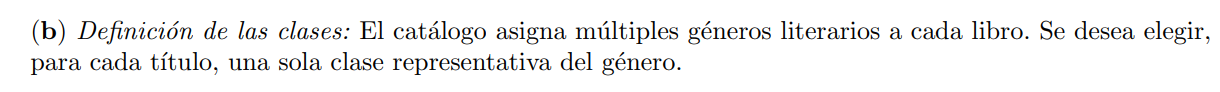

1. Analizar la distribucion de libros por categorıa.

Géneros
Otros                                                  795
Drama                                                  642
Policial                                               607
Aventuras                                              568
Realista                                               531
                                                      ... 
Didáctico, Fantástico, Juvenil                           1
Ucronía                                                  1
Espiritualidad, Filosofía, Obras completas               1
Aventuras, Didáctico, Fantástico, Infantil               1
Arte, Ciencias sociales, Crítica y teoría literaria      1
Name: count, Length: 596, dtype: int64


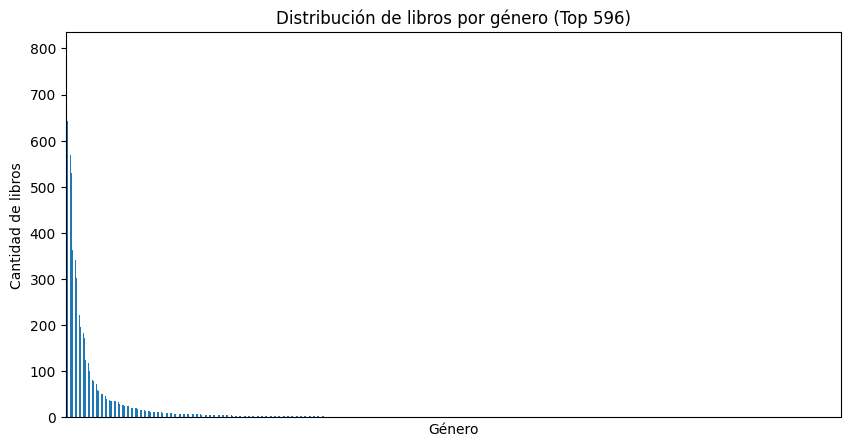

In [15]:
generos = cat_esp_dig['Géneros'].value_counts()
print(generos)
cant = len(generos)
generos.head(cant).plot(kind='bar', figsize=(10,5))
plt.title(f'Distribución de libros por género (Top {cant})')
plt.xlabel('Género')
plt.ylabel('Cantidad de libros')
plt.xticks(rotation=45, ha='right')
plt.xticks([], [])  # oculta las etiquetas y las marcas del eje X
plt.show()

Parece ser una exponencial decreciente con los mayores siendo:

Otros                                                  795

Drama                                                  642

Policial                                               607

Aventuras                                              568

Realista                                               531

y muchos otros.

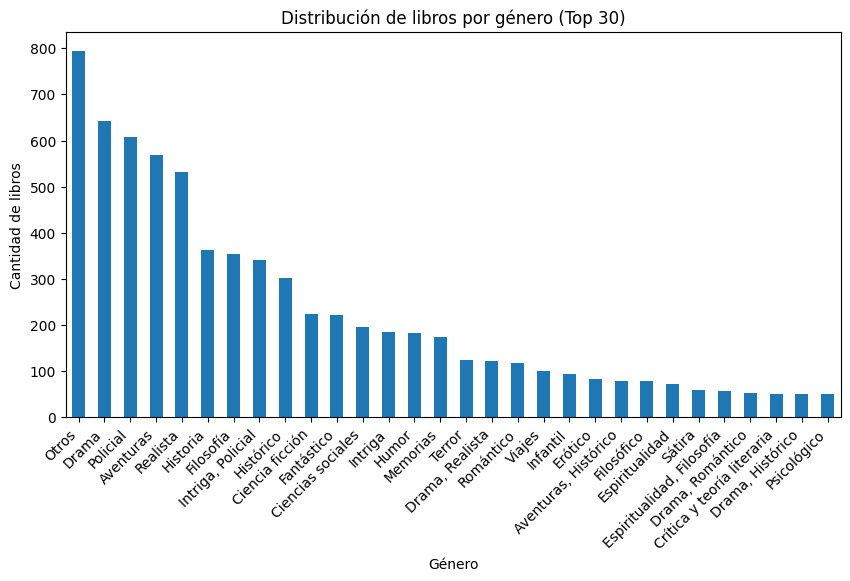

In [16]:
cant = 30
generos.head(cant).plot(kind='bar', figsize=(10,5))
plt.title(f'Distribución de libros por género (Top {cant})')
plt.xlabel('Género')
plt.ylabel('Cantidad de libros')
plt.xticks(rotation=45, ha='right')
plt.show()

2. Eliminar el genero Otros por ser una categorıa redundante.

In [17]:
cat_esp_dig = cat_esp_dig[cat_esp_dig['Géneros'] != 'Otros']

In [18]:
cat_esp_dig['Géneros'].value_counts() #OK listo

,count
Géneros,
Drama,642
Policial,607
Aventuras,568
Realista,531
Historia,362
...,...
"Didáctico, Fantástico, Juvenil",1
Ucronía,1
"Espiritualidad, Filosofía, Obras completas",1


3. Proponer y justificar un criterio para elegir un unico genero cuando un libro tenga varios.

Estoy entre dos opciones: Tomar el primero que aparezca esperando que las editoriales hayan clasificado de mayor a menor importancia para cuando un libro tiene mas de un genero.

Pero para evitar generar mas categorias segun preferencias de los creadores, tomo el mas frecuente entre los que aparecen siempre para que sea mejor aplicable el analisis estadistico.

In [19]:
# contar frecuencia de todos los géneros
todos_generos = cat_esp_dig['Géneros'].str.split(',').sum()
frecuencia = Counter([g.strip() for g in todos_generos])

# función para elegir el género más común entre los del libro
def genero_mas_frecuente(generos):
    if pd.isna(generos): return None
    lista = [g.strip() for g in generos.split(',')]
    return max(lista, key=lambda g: frecuencia[g])
cat_esp_dig['Genero_principal'] = cat_esp_dig['Géneros'].apply(genero_mas_frecuente)

In [20]:
cat_esp_dig['Genero_principal'].value_counts()
#Historia Histórico
#Filosofía  Filosófico
#Psicológico Psicología
#Ciencias sociales	Sociología

,count
Genero_principal,
Drama,1201
Policial,978
Aventuras,947
Realista,685
Filosofía,553
Historia,506
Histórico,371
Fantástico,364
Humor,277


In [21]:
cat_esp_dig['Genero_principal']
# Diccionario de normalización de géneros
reemplazos = {
    # === Agrupaciones principales ===
'Histórico': 'Historia',
'Filosófico'  :'Filosofía',
'Psicológico' :'Psicología',
'Sociología' :	'Ciencias sociales'
}
# limpio mi columna
cat_esp_dig['Géneros'] = cat_esp_dig['Genero_principal'].replace(reemplazos)
cat_esp_dig = cat_esp_dig.drop(columns=['Genero_principal']) #Ya hice lo que tenia que hacer



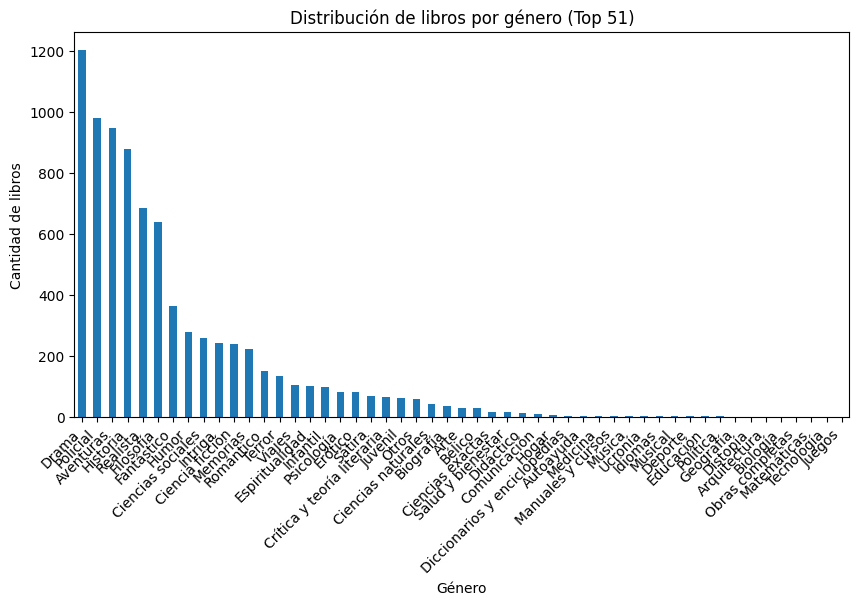

In [22]:
cant = len(cat_esp_dig['Géneros'].value_counts())
cat_esp_dig['Géneros'].value_counts().head(cant).plot(kind='bar', figsize=(10,5))
plt.title(f'Distribución de libros por género (Top {cant})')
plt.xlabel('Género')
plt.ylabel('Cantidad de libros')
plt.xticks(rotation=45, ha='right')
plt.show()

Sigue siendo una distribucion exponencial decreciente, tiene sentido que para libros que se leen en general los mas populares sean Drama, Policial, Aventuras, Realista, Historia y asi siguiendo

5. Separar los libros para definir conjuntos de entrenamiento y testeo utilizando las proporciones 75/25.
Fijar la semilla para reproducibilidad utilizando su numero de padron.

In [23]:
train, test = train_test_split(cat_esp_dig,test_size=0.25,random_state=109537 )


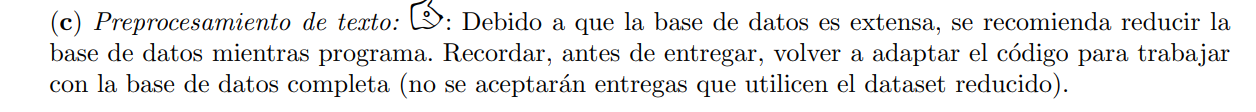

1. El formato de libros epub es un archivo comprimido zip que contiene la metada y estructura del
libro, archivos multimedia y archivos xhtml con el texto del libro. Extraer el texto de esos archivos.
Podra realizarlo manualmente o valerse de bibliotecas.

Tarda 40 minutos, con el profe hablamos y lo bajamos a 1000...

In [24]:
# Uso solo los primeros 100 libros durante desarrollo
uso_tp = cat_esp_dig.head(1000)
#uso_tp = cat_esp_dig

def extraer_texto_epub(ruta_epub):
    try:
        libro = epub.read_epub(ruta_epub)
        texto = ''
        for item in libro.get_items():
            if item.get_type() == ebooklib.ITEM_DOCUMENT:
                soup = BeautifulSoup(item.get_content(), 'html.parser')
                texto += soup.get_text(separator=' ', strip=True) + ' '
        return texto
    except Exception as e:
        print(f"Error con {ruta_epub}: {e}")
        return ''
uso_tp['texto'] = uso_tp['EPL Id'].apply(
    lambda x: extraer_texto_epub(f'epubs/compressed/{x}.epub')
)
uso_tp[['Título', 'texto']].head()


/tmp/ipython-input-1111743203.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uso_tp['texto'] = uso_tp['EPL Id'].apply(


,Título,texto
3,Memorias del mariscal de campo,7 LA CAMPAÑA CONTRA POLONIA 1939 A última hora...
20,La ciudadela,PRIMERA PARTE SEGUNDA PARTE TERCERA PARTE CUAR...
27,La filosofía como ciencia estricta,NOTA PRELIMINAR «Philosophie als strenge Wisse...
33,El sabor de la tierruca,EL SABOR DE LA TIERRUCA Índice de contenido Cu...
35,El hombre del hotel Carlton,Portadilla 1 Índice de contenido Cubierta El H...


2. Aplicar CountVectorizer (sklearn) al texto. Ajustar max_df, min_df y stop_words a criterio personal, justificando las decisiones. c: El corpus de texto completo es demasiado extenso para la
memoria. Se sugiere el uso de Generators para procesar el texto plano on-demand.

In [25]:
stopwords_es = stopwords.words('spanish')
vectorizer = CountVectorizer(
    max_df=0.8,          # Ignora palabras que aparecen en más del 80% de los documentos
    min_df=5,            # Ignora palabras que aparecen en menos de 5 documentos
    stop_words=stopwords_es # Elimina palabras vacías (como "el", "la", "de", "y")
)


| Parámetro              | Explicación                           | Justificación                                                                                          |
| ---------------------- | ------------------------------------- | ------------------------------------------------------------------------------------------------------ |
| `max_df=0.8`           | Excluye palabras demasiado frecuentes | Palabras que aparecen en casi todos los libros (como “capítulo” o “autor”) no aportan valor semántico. |
| `min_df=5`             | Excluye palabras muy raras            | Filtra palabras que aparecen en muy pocos libros, reduciendo ruido y tamaño del vocabulario.           |
| `stop_words='spanish'` | Usa lista de *stopwords* en español   | Elimina artículos, preposiciones y conectores comunes del idioma.                                      |


In [31]:
def generador_textos(df):
    for texto in df['texto']:
        yield texto

In [32]:
textos = generador_textos(uso_tp)
X = vectorizer.fit_transform(textos)
#print(X)
#Lo hice solamente para la consigna
#Anda bien igual, no lo use despues....

3. Se desea comprobar el funcionamiento del vectorizador. Para ello, aplicar el vectorizador ya entrenado a dos obras clasicas del catalogo de diferentes generos (por ejemplo, “Estudio en escarlata”
y “Orgullo y prejuicio”). Descartar las palabras presentes en ambos libros. Luego, para cada libro,
reportar las 40 palabras mas frecuentes. Interpretar los resultados obtenidos.

In [33]:
print(uso_tp['Título'].value_counts())

Título
Cartas                                               2
La cueva de ladrones                                 1
Coloquio de las damas                                1
María la bizca                                       1
Leyendas de Guatemala                                1
                                                    ..
El culto moderno a los monumentos                    1
El amante de lady Chatterley (trad. Andrés Bosch)    1
Elmer Gantry                                         1
Obras (Opera Omnia)                                  1
Los amores de un loco                                1
Name: count, Length: 999, dtype: int64


In [34]:
# Selecciono los dos primeros de arriba (del value counts)
libro1 = uso_tp[uso_tp['Título'].str.contains("Memorias del mariscal de campo", case=False, na=False)].iloc[0]
libro2 = uso_tp[uso_tp['Título'].str.contains("La ciudadela", case=False, na=False)].iloc[0]

# Transformo ambos textos con el vectorizador entrenado antes
X1 = vectorizer.transform([libro1['texto']])
X2 = vectorizer.transform([libro2['texto']])

# Convierto a DF para analizar las palabras.
palabras = np.array(vectorizer.get_feature_names_out())

freq1 = pd.DataFrame({'palabra': palabras, 'freq': X1.toarray().flatten()})
freq2 = pd.DataFrame({'palabra': palabras, 'freq': X2.toarray().flatten()})

# Filtrar palabras presentes en ambos
palabras_comunes = set(freq1.loc[freq1['freq'] > 0, 'palabra']).intersection(
    set(freq2.loc[freq2['freq'] > 0, 'palabra'])
)

freq1_filtrado = freq1[~freq1['palabra'].isin(palabras_comunes) & (freq1['freq'] > 0)]
freq2_filtrado = freq2[~freq2['palabra'].isin(palabras_comunes) & (freq2['freq'] > 0)]

# Top 40 palabras únicas más frecuentes por libro
top1 = freq1_filtrado.sort_values('freq', ascending=False).head(40)
top2 = freq2_filtrado.sort_values('freq', ascending=False).head(40)

print("Palabras mas frecuentes Memorias del mariscal de campo:")
print(top1)

print("Palabras mas frecuentes La ciudadela:")
print(top2)


Palabras mas frecuentes Memorias del mariscal de campo:
            palabra  freq
19183         aérea   472
50437     ejércitos   341
48239      división   318
30683    comandante   301
85193         mando   295
70925        hitler   273
48237    divisiones   263
78613        italia   199
63802         flota   169
18781       aviones   165
135163    wehrmacht   163
116188       rommel   158
8933        aliados   154
82161     liderazgo   143
86054      mariscal   139
8716       alemanas   137
64146   formaciones   137
8717       alemanes   133
19185         aéreo   131
83810     luftwaffe   126
123899  suministros   124
116125         roma   113
19184        aéreas   110
88318       militar   108
15662    artillería   107
121591     soldados   107
67316       goering    97
78618     italianas    95
115564          rin    90
130850        túnez    87
78623      italiano    87
30684   comandantes    87
30689       comando    83
107099     pérdidas    83
78624     italianos    83
94026   

##**Analisis**
### Memorias del mariscal de campo
Para ver que este haciendo las cosas bien el buscador, busque una resenia del libro en google:

Contenido: Kesselring describe su formación militar, su participación en la Primera Guerra Mundial, la creación de la Luftwaffe y su mando en diversos frentes, como el Mediterráneo (donde tuvo un papel defensivo eficaz en Italia) y el Frente Occidental.

Las palabras más frecuentes que aparecen (después de eliminar las comunes) —como aérea, ejércitos, división, comandante, hitler, mariscal, soldados, flota, artillería, aviación, militares— reflejan terminología militar y contexto bélico.


Parece que el modelo identifica correctamente que el vocabulario dominante pertenece al ámbito de la guerra (estructuras jerárquicas, operaciones, y nombres propios asociados al conflicto).
Esto coincide con la naturaleza del libro — unas memorias de un general alemán durante la Segunda Primera Mundial.

El vectorizador está captando con precisión los términos característicos del género histórico-militar.

---
### La ciudadela

Contenido (Google):
En octubre de 1924, Andrew Manson, un médico idealista recién titulado, llega de Escocia para trabajar como asistente del doctor Page en el pequeño pueblo minero (ficticio) galés de Drineffy (Blaenelly es el nombre que recibe en algunas adaptaciones). Pronto se da cuenta de que Page está enfermo e incapacitado y que tiene que hacer todo el trabajo por un salario miserable. Horrorizado por las condiciones insalubres que descubre, Manson se esfuerza por mejorar la situación y recibe el apoyo del doctor Philip Denny, un cínico y alcohólico que, como Manson descubre más adelante, aceptó un puesto de médico asistente tras haber caído en desgracia como cirujano. Tras dimitir, consigue un puesto como asistente en un programa de asistencia médica para mineros en Aberalaw, un pueblo minero vecino en la cuenca carbonífera del sur de Gales . Gracias a este trabajo, Manson se casa con Christine Barlow, una maestra de escuela primaria.

Las palabras más frecuentes —como andrés, cristina, enfermera, enfermos, paciente, medicina, clínica, médica, lawrence, felipe, sonrió, querida, supongo— reflejan una mezcla entre:

Vocabulario médico (enfermera, medicina, clínica, paciente)

Vocabulario social y emocional (querida, sonrió, supongo, señorita)

Nombres propios de los personajes.

El modelo resalta el tono humano, interpersonal y cotidiano de la historia, centrada en la práctica médica y las relaciones personales.

El vectorizador logra distinguir claramente un campo léxico diferente del caso anterior: más íntimo, emocional y profesional, propio del drama social.

---

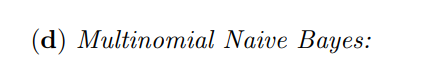

##**Analisis teorico**

Las redes Bayesianas son un grafico aciclico dirigido que representa la relacion de causalidad e independencia de sus variables. Dos VA cualesquiera son condicionalmente independientes dados los valores de sus padres causales (por lo tanto tambien las raices).


Se suele elegir como estimador puntual el maximo a posteriori y el bayesiano como media a posteriori, no son necesarios los estimadores puntuales para predecir..


La filosofia bayesiana interpreta la probabilidad como uan medida de credibilidad en un evento. Por eso se habla de que el enfoque Bayesiano busca verdades en contexto de incertidumbre.

Lo que lo hace naive es asumir que hay una causalidad $Y → X$ con lasdiferentes componentes $X_j|Y=k$ independientes.


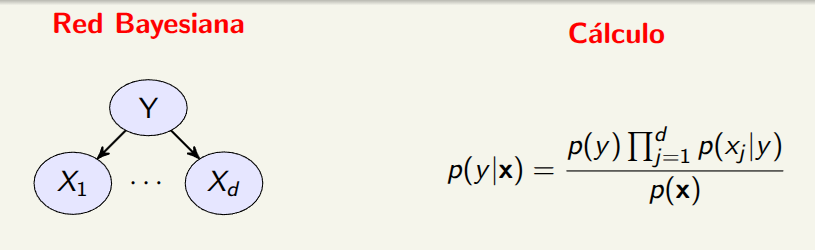


###**Parametros**
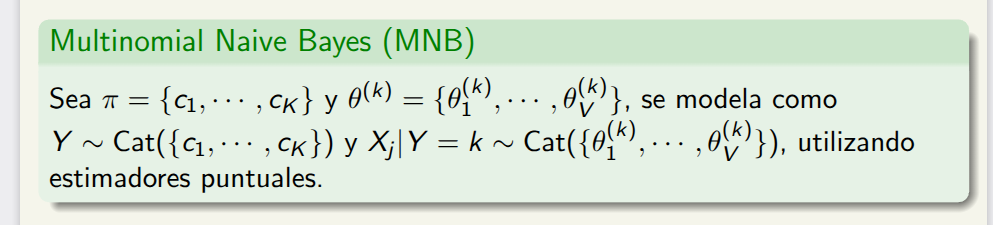

Donde $\pi = {c_1,...,c_k}$ son las clases posibles, los $\theta_m^k$ es la probabilidad de observar la palabra o caracteristica m en la clase k, $Y$ se distribuye categoricamente entre las clases con alguna probabilidad $P(Y=c_k)$. $X_j|Y=k$ es tamen categorica controlada por los parametros $\theta^k$ de su clase.


Cada clase $c_k$ tiene un vector probabilidades $\theta^k$ que describe que tan probable es cada palabra. Cada observacion $X_j$ se genera segun esa distribucion condicionada a la clase $Y=k$


##***Inferencia***
La probabilidad de que una clase $y$ dado una muestra $x$ es proporcional a una constante de proporcionalidad previa de la clase $P(Y=y)$ por la productoria que la palabraj ocurra en la clase y.


Esta distribucion es contar cuantas veces ocurre una palabra en el total dado que hay k casos posibles, es decir es el caso general de una binomial. Con esta probabilidad se calcula el maximo. Es decir, nosotros vamos a aprender una frecuencia relativa de palabras para ciertos tipos de generos con el entrenamiento, luego, para el testeo, le vamos a pasar tambien palabras afines y el maximo de aquellas va a definir la clase predecida sobre el conjunto.

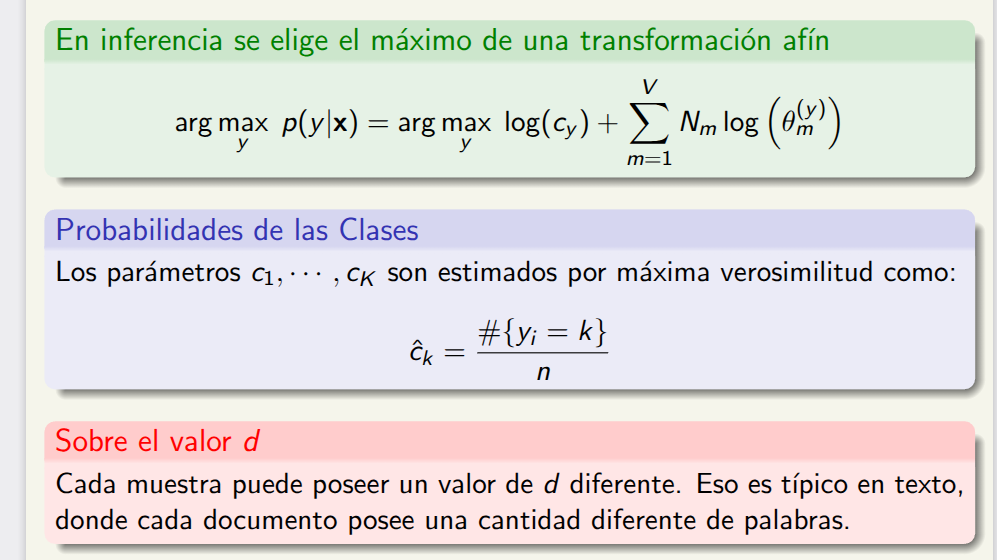


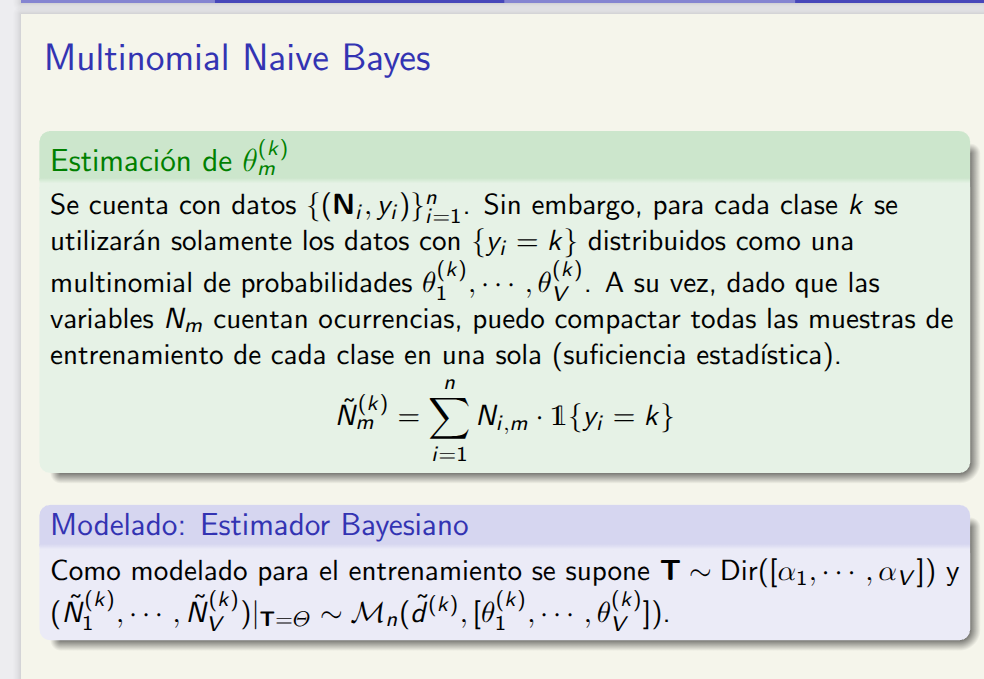

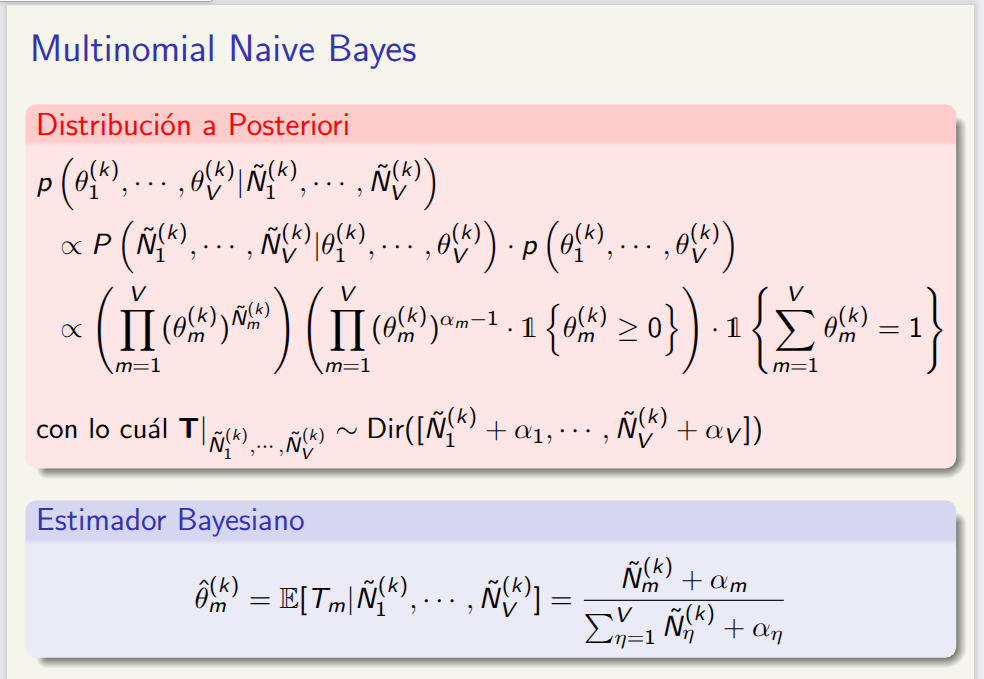

---
##**Codigo**

In [35]:
class MultinomialNB_Numpy:
    def __init__(self, alpha=1.0):
        # El parámetro alpha representa el suavizado de Laplace.
        # Se utiliza para evitar que una palabra con frecuencia cero
        # anule la probabilidad de toda la clase.
        self.alpha = alpha
        self.class_log_prior_ = None       # Guarda los logaritmos de las probabilidades a priori de cada clase.
        self.feature_log_prob_ = None      # Guarda los logaritmos de las probabilidades de cada palabra por clase.
        self.classes_ = None               # Guarda las etiquetas de las clases.

    def fit(self, X, y):
        """
        Ajusta el modelo a los datos de entrenamiento.
        X es una matriz documentos x palabras (o características),
        y es el vector con las clases correspondientes a cada documento.
        """
        if sparse.issparse(X):
            X = X.tocsr()  # Si la matriz es dispersa, se convierte a formato CSR para operaciones eficientes.

        # Identifica las clases únicas y cuenta cuántos documentos hay por clase.
        self.classes_, class_counts = np.unique(y, return_counts=True)
        n_classes = len(self.classes_)
        n_features = X.shape[1]

        # Calcula la probabilidad a priori de cada clase como la frecuencia relativa de documentos.
        # Se trabaja en logaritmos para evitar problemas numéricos.
        self.class_log_prior_ = np.log(class_counts / class_counts.sum())

        # Se inicializa una matriz para acumular las cuentas de palabras por clase.
        smoothed_fc = np.zeros((n_classes, n_features))

        # Para cada clase, se suman las frecuencias de cada palabra en todos los documentos de esa clase.
        # Luego se aplica el suavizado de Laplace sumando alpha.
        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]                                # Filtra los documentos que pertenecen a la clase actual.
            smoothed_fc[idx, :] = np.asarray(X_c.sum(axis=0)).flatten() + self.alpha

        # Se normaliza por el total de palabras en la clase para obtener una distribución de probabilidad.
        smoothed_feature_sum = smoothed_fc.sum(axis=1).reshape(-1, 1)
        self.feature_log_prob_ = np.log(smoothed_fc / smoothed_feature_sum)

        return self

    def predict_log_proba(self, X):
        """
        Devuelve el logaritmo de la probabilidad posterior de cada clase dado el documento.
        La relación es proporcional a log(P(y)) + sum_i x_i * log(P(x_i | y)).
        """
        if sparse.issparse(X):
            X = X.tocsr()
        return (X @ self.feature_log_prob_.T) + self.class_log_prior_

    def predict_proba(self, X):
        """
        Devuelve las probabilidades normalizadas de pertenecer a cada clase.
        Se parte de las log-probabilidades y se aplican transformaciones
        para obtener valores reales normalizados entre 0 y 1.
        """
        log_probs = self.predict_log_proba(X)
        log_probs -= log_probs.max(axis=1, keepdims=True)  # Estabiliza los valores restando el máximo por fila.
        probs = np.exp(log_probs)                          # Se pasa de log a probabilidad.
        return probs / probs.sum(axis=1, keepdims=True)    # Normaliza por el total para que sumen 1.

    def predict(self, X):
        """
        Predice la clase más probable para cada documento.
        Se elige la clase con la mayor probabilidad posterior.
        """
        log_probs = self.predict_log_proba(X)
        return self.classes_[np.argmax(log_probs, axis=1)]


In [36]:
train, test = train_test_split(uso_tp,test_size=0.25,random_state=109537 )
def limpiar_texto(texto):
    if not isinstance(texto, str):
        return ""
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúüñ\s]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto
train['texto_limpio'] = train['texto'].apply(limpiar_texto)
test['texto_limpio'] = test['texto'].apply(limpiar_texto)


In [37]:

stopwords_es = stopwords.words('spanish')

vectorizer = CountVectorizer(
    max_df=0.8,
    min_df=5,
    stop_words=stopwords_es
)


X_train = vectorizer.fit_transform(train['texto_limpio'])
X_test = vectorizer.transform(test['texto_limpio'])

y_train = train['Géneros']
y_test = test['Géneros']


In [38]:
mnb_np = MultinomialNB_Numpy(alpha=1.0)
mnb_np.fit(X_train, np.array(y_train))


In [39]:
y_pred = mnb_np.predict(X_test)

accuracy = np.mean(y_pred == np.array(y_test))
print(f"Accuracy del clasificador MNB: {accuracy:.3f}")


Accuracy del clasificador MNB: 0.504


In [40]:
# Creo DataFrame con predicciones y etiquetas verdaderas
resultados = test.copy()
resultados['Predicho'] = y_pred
resultados['Correcto'] = resultados['Predicho'] == resultados['Géneros']

# Filtrar errores (clasificaciones incorrectas)
errores = resultados[resultados['Correcto'] == False]

# Tomar las 10 obras más populares (por número de votos)
errores_top10 = errores.sort_values(by='Nº Votos', ascending=False).head(10)

# Mostrar resultados
cols = ['Título', 'Autor', 'Géneros', 'Predicho', 'Valoración', 'Nº Votos', 'Sinopsis']
print("Obras más populares clasificadas incorrectamente:\n")
display(errores_top10[cols])

# F1 global (promedio ponderado según cantidad de muestras por clase)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"🔹 F1-score (ponderado): {f1:.3f}")

# También podés ver un resumen completo por clase:
print("\n Reporte de clasificación completo:\n")
print(classification_report(y_test, y_pred))




Obras más populares clasificadas incorrectamente:



,Título,Autor,Géneros,Predicho,Valoración,Nº Votos,Sinopsis
1584,Don Quijote de la Mancha (IV CENTENARIO),Miguel de Cervantes Saavedra,Aventuras,Historia,9.4,256,Poco puede decirse del Quijote que no se haya ...
84,El corazón de las tinieblas [T. Araceli e Isabel],Joseph Conrad,Drama,Aventuras,8.3,80,Tejida en torno a una anécdota mínima —el viaj...
2993,Musashi,Eiji Yoshikawa,Historia,Drama,9.3,75,Una saga épica monumental sobre la vida y anda...
843,Nosotros,Yevgueni Zamiatin,Ciencia ficción,Drama,8.0,62,En la ciudad de cristal y acero del Estado Úni...
5071,La montaña mágica,Thomas Mann,Filosofía,Drama,8.8,53,"La montaña mágica (Der Zauberberg, en el origi..."
6687,Las once mil vergas,Guillaume Apollinaire,Erótico,Realista,7.1,48,"«Más fuerte que el Marqués de Sade», así calif..."
2774,Cartas del diablo a su sobrino,C. S. Lewis,Humor,Filosofía,8.8,42,El eterno clásico sobre «las últimas novedades...
4463,Desobediencia civil y otros escritos,Henry David Thoreau,Filosofía,Ciencias sociales,9.1,40,"Figura singular y enemiga de convenciones, el ..."
5699,Más que humano,Theodore Sturgeon,Ciencia ficción,Drama,8.8,40,Más que humano es la historia de un grupo de p...
5708,La espada rota,Poul Anderson,Fantástico,Aventuras,8.4,37,En una tierra en la que el reino de Faerie exi...


🔹 F1-score (ponderado): 0.467

 Reporte de clasificación completo:

                              precision    recall  f1-score   support

                        Arte       0.00      0.00      0.00         1
                   Aventuras       0.65      0.58      0.61        19
                   Biografía       0.60      0.60      0.60         5
                      Bélico       0.00      0.00      0.00         1
             Ciencia ficción       1.00      0.75      0.86         8
          Ciencias naturales       0.00      0.00      0.00         2
           Ciencias sociales       0.42      0.71      0.53         7
  Crítica y teoría literaria       0.00      0.00      0.00         2
Diccionarios y enciclopedias       0.00      0.00      0.00         0
                   Didáctico       0.00      0.00      0.00         1
                       Drama       0.42      0.72      0.53        36
                     Erótico       0.00      0.00      0.00         4
              Espirit

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

## **Análisis de resultados**

El modelo Multinomial Naive Bayes alcanzó un F1-score ponderado de 0.467 y un accuracy total de 0.504, lo que indica un rendimiento moderado, con una capacidad razonable para distinguir ciertos géneros. Contra el clasificador dummy, funciona muy bien (vs elegir siempre el de mayor probabilidad).

---

### **Rendimiento general**

El modelo logra capturar con cierta precisión los patrones léxicos más evidentes, pero presenta grandes variaciones entre clases.
Como es típico del enfoque Naive Bayes, que asume independencia entre términos, su efectividad se reduce cuando los textos comparten vocabulario entre géneros o presentan estructuras narrativas complejas.

Además, la distribución desbalanceada de géneros (más ejemplos de “Drama”, “Historia”, “Policial”, etc.) influye negativamente en la capacidad del modelo para generalizar hacia categorías minoritarias.

El Desbalance severo entre clases (pocas muestras en géneros minoritarios), el solapamiento semántico entre géneros narrativos (Drama, Realista, Aventuras), la falta de información contextual o sintáctica, ya que el modelo usa solo conteo de palabras.

---

###**Conclusión**

El clasificador Multinomial Naive Bayes logra un rendimiento base aceptable (Accuracy ≈ 0.50), siendo capaz de reconocer géneros con vocabularios bien definidos, pero fallando en categorías difusas o narrativamente complejas.

